<a href="https://colab.research.google.com/github/cfcastillo/DS-6-Notebooks/blob/main/2_Education_Capstone_EDA_and_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Definition

The purpose of this project is to identify what factors influence people to choose certain professions or trades. In understanding these factors, we can help colleges like Central New Mexico College (CNM) offer courses that support those professions and better target their marketing to people who are likely to choose those professions.

This project will be a supervised categorization problem using tree-based models to identify the factors that will contribute to career choice.



# References

[Oversampling and Undersampling](https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/)

# Data Collection and Cleaning

The data collection and cleaning process is outlined in the notebook titled [1. Education Capstone - Data Collection and Cleaning.ipynb](https://colab.research.google.com/drive/1Y_1b7BmiRF6CSYnoiZqGpfjpbzU4qoFe#scrollTo=Kmxlgo4Wnjgd)


## Column Descriptions

[Here is a summary document showing selected columns.](https://docs.google.com/document/d/1io7TtqebJLtw6FKE7zkbUh26QkG3rEJrZX3Fver9zmU/edit)

[Keeping notebook from disconnecting](https://www.rockyourcode.com/script-to-stop-google-colab-from-disconnecting/)

# Imports

In [ ]:
# grab the imports needed for the project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# import statsmodels.api as sm

from sklearn import metrics
from sklearn.metrics import classification_report
# import sklearn.model_selection as model_selection
# from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# from mlxtend.plotting import plot_decision_regions

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Visualization
import graphviz
# from IPython.display import display
# from sklearn import tree
# import plotly.express as px
# from ipywidgets import interact, Dropdown

# Other
# from sklearn.pipeline import Pipeline # Breaks if you use with over/under samplers
from imblearn.pipeline import Pipeline  # Need this pipeline to use over/under samplers

# Exploratory Data Analysis (EDA)

In our EDA, we will first filter our data to focus in on our features of interest and prepare our data for analysis. Then we will generate summary statistics to identify anomalies and visualize our data to better understand our variables and the relationships between them. Finally, we will reflect on the analysis and determine next steps.

##Import and filter data

We'll first import our clean dataset. We'll also be dropping some observations, such as those employed in the armed forces, who don't have enough observations to support significant analysis. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The team had different data links. The global here is to allow team members to specify who is working on this notebook so that they can run the code in their environment.

In [ ]:
# Expected values are: ellie, amy, cecilia - lowercase
team_member = 'cecilia'

# Root drive path
if team_member in ['amy','ellie']:
  root_drive = '/content/drive/MyDrive/'
else: # Cecilia
  root_drive = '/content/drive/MyDrive/Student Folder - Cecilia/Projects/'

In [ ]:
#Import final data

asec_final = pd.read_csv(root_drive + 'Capstone/Data/FinalData/asec_2021v1.csv')

#Drop rows where A_CLSWKR codes are equal to 0 or 8 and A_DTOCC equals 23
asec_final.drop(np.where((asec_final['A_CLSWKR'] == 8) | (asec_final['A_CLSWKR'] == 0) | (asec_final['A_DTOCC'] == 23)) [0], inplace=True)

#Drop 'Unnamed: 0' column
asec_final.drop('Unnamed: 0', axis=1, inplace=True)

## Understand our Data
To better understand our data we'll look at the general shape, values, and summarys statistics of the dataset.

In [ ]:
#Get dimensions of datset
asec_final.shape

(78832, 49)

In [ ]:
#Look at the first five rows
asec_final.head()

,GTMETSTA,GEDIV,GESTFIPS,HHINC,H_TENURE,H_LIVQRT,OCCUP,A_MJOCC,A_DTOCC,AGE1,A_SEX,PRDTRACE,PXRACE1,PRCITSHP,A_HGA,PRERELG,A_GRSWK,HRCHECK,HRSWK,PEARNVAL,A_CLSWKR,WEIND,A_MARITL,A_HSCOL,A_WKSTAT,HEA,PEINUSYR,FKINDEX,FINC_FR,FINC_SE,FINC_WS,FINC_ANN,FINC_CSP,FINC_DIS,FINC_DIV,FINC_RNT,FINC_DST,FINC_ED,FINC_SS,FINC_SSI,FINC_FIN,FINC_SUR,FINC_INT,FINC_UC,FINC_OI,FINC_VET,FINC_PAW,FINC_WC,FINC_PEN
1,2,1,23,11,1,1,6305,7,19,12,1,1,0,1,39,0,0,2,40,10000,1,3,1,0,6,3,0,1,2,2,1,2,2,2,2,2,2,2,1,2,2,2,2,1,2,2,2,2,2
3,2,1,23,41,1,1,2002,2,6,15,2,1,0,1,43,1,827,2,40,43000,1,15,1,0,2,3,0,1,2,2,1,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
4,2,1,23,41,1,1,9130,10,22,15,1,1,0,1,39,1,635,2,40,33000,1,8,1,0,2,3,0,1,2,2,1,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
5,2,1,23,41,1,1,9645,10,22,6,1,1,0,1,43,1,481,2,40,25000,1,7,7,0,2,2,0,1,2,2,1,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
8,2,1,23,28,2,1,310,1,1,10,2,1,0,1,39,0,0,2,50,60000,6,18,5,0,2,2,0,3,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2


In [ ]:
#Get info about each column
asec_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78832 entries, 1 to 129109
Data columns (total 49 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   GTMETSTA  78832 non-null  int64
 1   GEDIV     78832 non-null  int64
 2   GESTFIPS  78832 non-null  int64
 3   HHINC     78832 non-null  int64
 4   H_TENURE  78832 non-null  int64
 5   H_LIVQRT  78832 non-null  int64
 6   OCCUP     78832 non-null  int64
 7   A_MJOCC   78832 non-null  int64
 8   A_DTOCC   78832 non-null  int64
 9   AGE1      78832 non-null  int64
 10  A_SEX     78832 non-null  int64
 11  PRDTRACE  78832 non-null  int64
 12  PXRACE1   78832 non-null  int64
 13  PRCITSHP  78832 non-null  int64
 14  A_HGA     78832 non-null  int64
 15  PRERELG   78832 non-null  int64
 16  A_GRSWK   78832 non-null  int64
 17  HRCHECK   78832 non-null  int64
 18  HRSWK     78832 non-null  int64
 19  PEARNVAL  78832 non-null  int64
 20  A_CLSWKR  78832 non-null  int64
 21  WEIND     78832 non-null  int64
 2

In [ ]:
#Get summary statistics for each column
asec_final.describe()

,GTMETSTA,GEDIV,GESTFIPS,HHINC,H_TENURE,H_LIVQRT,OCCUP,A_MJOCC,A_DTOCC,AGE1,A_SEX,PRDTRACE,PXRACE1,PRCITSHP,A_HGA,PRERELG,A_GRSWK,HRCHECK,HRSWK,PEARNVAL,A_CLSWKR,WEIND,A_MARITL,A_HSCOL,A_WKSTAT,HEA,PEINUSYR,FKINDEX,FINC_FR,FINC_SE,FINC_WS,FINC_ANN,FINC_CSP,FINC_DIS,FINC_DIV,FINC_RNT,FINC_DST,FINC_ED,FINC_SS,FINC_SSI,FINC_FIN,FINC_SUR,FINC_INT,FINC_UC,FINC_OI,FINC_VET,FINC_PAW,FINC_WC,FINC_PEN
count,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,7.883200e+04,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000,78832.000000
mean,1.181272,5.505011,27.832834,32.221179,1.314872,1.161889,3886.677200,3.968287,11.979133,9.095329,1.479323,1.531548,1.987974,1.623516,40.889499,0.211703,153.638941,1.754820,37.504516,5.749959e+04,1.802961,12.184849,3.435800,0.121816,2.565240,2.108953,3.010288,2.006825,1.978245,1.879250,1.046250,1.989915,1.964761,1.982165,1.786559,1.924485,1.975543,1.935496,1.865511,1.980782,1.988406,1.989015,1.276132,1.804762,1.981302,1.975847,1.992034,1.992161,1.952976
std,0.409321,2.524008,16.289146,11.231118,0.485121,0.814412,2758.630274,2.808246,6.967677,3.222822,0.499575,1.446914,7.752409,1.341081,2.633298,0.408518,468.301804,0.512719,13.157469,7.911178e+04,1.555167,5.977562,2.740684,0.457963,1.184818,0.927844,6.858710,1.284845,0.145884,0.325839,0.210028,0.099916,0.184386,0.132354,0.409739,0.264222,0.154464,0.245651,0.341179,0.137292,0.107051,0.104235,0.447085,0.396386,0.135457,0.153524,0.088899,0.088194,0.211692
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,-9.999000e+03,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,3.000000,12.000000,24.000000,1.000000,1.000000,1360.000000,2.000000,6.000000,7.000000,1.000000,1.000000,0.000000,1.000000,39.000000,0.000000,0.000000,2.000000,36.000000,2.000000e+04,1.000000,7.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,1.000000,5.000000,28.000000,40.000000,1.000000,1.000000,4020.000000,3.000000,13.000000,9.000000,1.000000,1.000000,0.000000,1.000000,40.000000,0.000000,0.000000,2.000000,40.000000,4.000000e+04,1.000000,13.000000,1.000000,0.000000,2.000000,2.000000,0.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,1.000000,8.000000,42.000000,41.000000,2.000000,1.000000,5600.000000,5.000000,17.000000,11.000000,2.000000,1.000000,0.000000,1.000000,43.000000,0.000000,0.000000,2.000000,40.000000,7.000000e+04,1.000000,16.000000,7.000000,0.000000,2.000000,3.000000,0.000000,3.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,3.000000,9.000000,56.000000,41.000000,3.000000,12.000000,9840.000000,10.000000,22.000000,17.000000,2.000000,26.000000,43.000000,5.000000,46.000000,1.000000,2885.000000,2.000000,99.000000,2.899899e+06,7.000000,23.000

In [ ]:
#See all column names
asec_final.columns

Index(['GTMETSTA', 'GEDIV', 'GESTFIPS', 'HHINC', 'H_TENURE', 'H_LIVQRT',
       'OCCUP', 'A_MJOCC', 'A_DTOCC', 'AGE1', 'A_SEX', 'PRDTRACE', 'PXRACE1',
       'PRCITSHP', 'A_HGA', 'PRERELG', 'A_GRSWK', 'HRCHECK', 'HRSWK',
       'PEARNVAL', 'A_CLSWKR', 'WEIND', 'A_MARITL', 'A_HSCOL', 'A_WKSTAT',
       'HEA', 'PEINUSYR', 'FKINDEX', 'FINC_FR', 'FINC_SE', 'FINC_WS',
       'FINC_ANN', 'FINC_CSP', 'FINC_DIS', 'FINC_DIV', 'FINC_RNT', 'FINC_DST',
       'FINC_ED', 'FINC_SS', 'FINC_SSI', 'FINC_FIN', 'FINC_SUR', 'FINC_INT',
       'FINC_UC', 'FINC_OI', 'FINC_VET', 'FINC_PAW', 'FINC_WC', 'FINC_PEN'],
      dtype='object')

We are particularly interested in the column A_DTOCC, which indicates the detailed occupation codes grouped by industry, because this is the attributed we are interested in modeling. Theremore, some more EDA will be focused on this column.

In [ ]:
#See unique values for target column, A_DTOCC
asec_final['A_DTOCC'].unique()

array([19,  6, 22,  1, 21, 10, 16, 20, 17, 12,  8,  2, 13, 18,  9, 14, 15,
       11,  7,  4,  3,  5])

In [ ]:
#See frequency for the A_DTOCC column
oc_freq = asec_final['A_DTOCC'].value_counts(ascending=True)
oc_freq

18     696
5      815
7      931
6     1438
4     1474
9     1492
12    1570
15    1918
20    2533
11    2570
3     2671
14    2965
13    4128
21    4166
2     4255
19    4359
8     4788
10    4845
22    5950
16    7271
17    8296
1     9701
Name: A_DTOCC, dtype: int64

In [ ]:
#See percentages for the A_DTOCC column
asec_final['A_DTOCC'].value_counts(ascending=True, normalize=True)

18    0.008829
5     0.010338
7     0.011810
6     0.018241
4     0.018698
9     0.018926
12    0.019916
15    0.024330
20    0.032132
11    0.032601
3     0.033882
14    0.037612
13    0.052365
21    0.052847
2     0.053976
19    0.055295
8     0.060737
10    0.061460
22    0.075477
16    0.092234
17    0.105236
1     0.123059
Name: A_DTOCC, dtype: float64

##Plots

###Correlation
Correlation is only appropriate for continuous variables, so we'll create a subset of variables to evaluate using this method. 

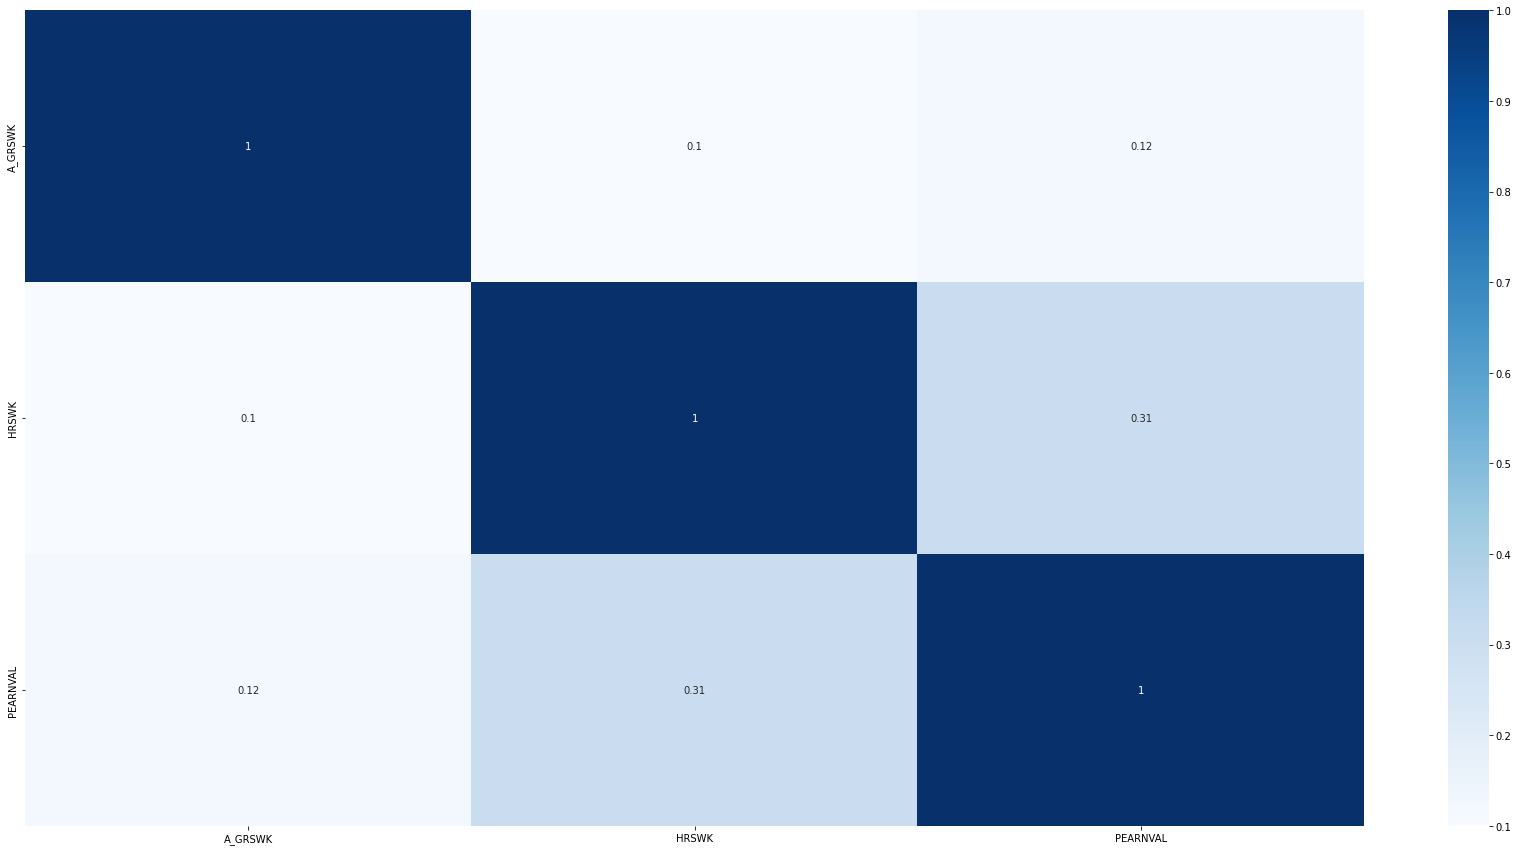

In [ ]:
# Correlation plot
correlation_df = asec_final.filter(items=['A_GRSWK', 'HRSWK', 'PEARNVAL'], axis=1)

plt.figure(figsize=(30,15))
correlation_matrix = correlation_df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='Blues')

In [ ]:
# Numerically looking at the correlations
corrs = correlation_df.corr().round(2).unstack().abs()
corrs = corrs[corrs < 1]
corrs.sort_values(ascending = False)

PEARNVAL  HRSWK       0.31
HRSWK     PEARNVAL    0.31
PEARNVAL  A_GRSWK     0.12
A_GRSWK   PEARNVAL    0.12
HRSWK     A_GRSWK     0.10
A_GRSWK   HRSWK       0.10
dtype: float64

None of these predictors appear to be highly correlated.

###Boxplots
We use boxplots to visualize the categorical variabe of occupational code against several continuous variables, including weekly earnings, total person's earnings, and weekly hours.

Text(0.5, 1.0, 'Weekly Hours Worked vs Coded Occupation')

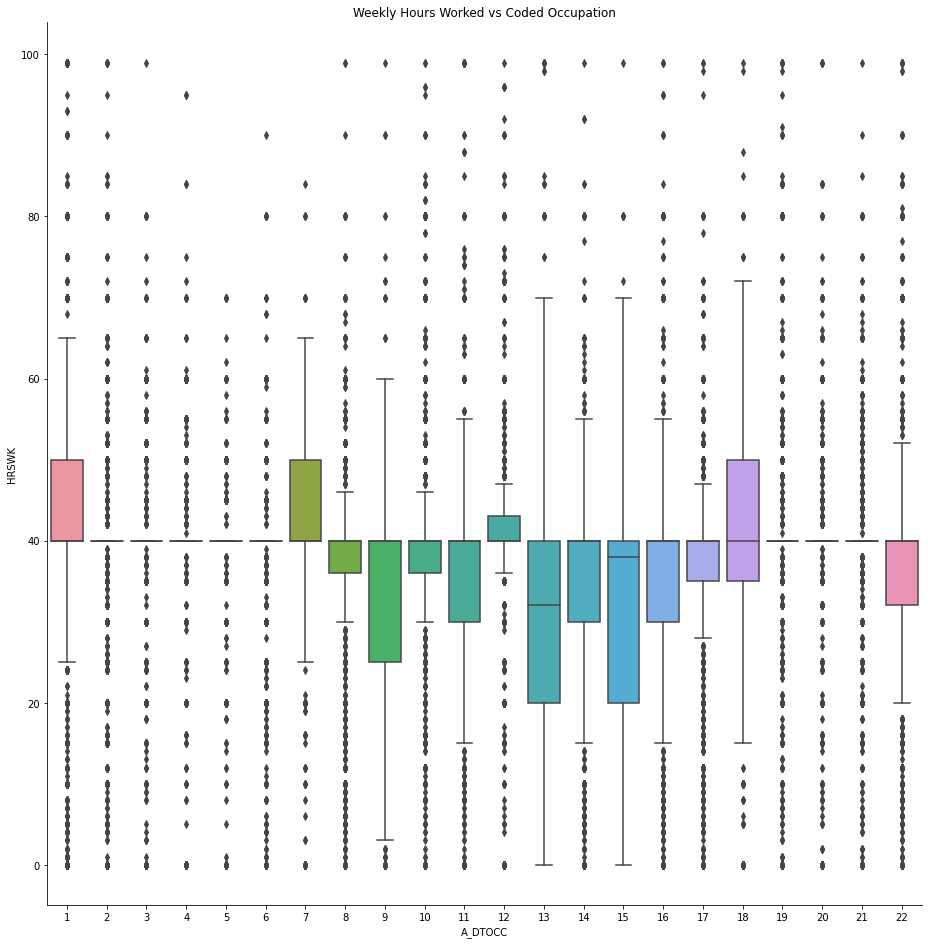

In [ ]:
sns.catplot(x="A_DTOCC", y="HRSWK", kind="box", data=asec_final, height=13)
plt.title('Weekly Hours Worked vs Coded Occupation')

##Reflection
The data are not normally distributed, but do show some interesting trends between our variables of interest (sex, occupational group, race, hours worked, etc). Depending on the model implemented, we may need to return to EDA to explicitly check assumptions for the model.

# Data Processing / Models


##Pre-processing: Balancing Classes
Because we're interested in predicting the occupation code of an individual based on their demographic data, it will be important to ensure all of our classes have equal representation in our training model. As it stands, our classes 1-22 range from a minimum of 871 observations (class 18) to a maximum of 10239 (class 1). To balance these classes, we'll randomly undersample all classes besides our minimum class. Depending on how well our model performs with the undersampled data, this method may need to be re-visited.

In [ ]:
# TODO: combine occupation codes that have low percentages to see if this improves model performance
# def createOtherOccupation(value):
#   if value == 7:
#     return 2
#   elif value == 23:
#     return 5
#   elif value == 1 or value == 21:
#     return 99
#   else:
#     return value

# asec_oes_final['NEW_OCC'] = asec_oes_final.apply(lambda x: createOtherOccupation(x['A_DTOCC']), axis=1)

In [ ]:
# Separating data into X and y data sets for applying models
family_cols = ['FINC_FR','FINC_SE','FINC_WS','FINC_CSP','FINC_DIS','FINC_DIV','FINC_RNT',
               'FINC_ED','FINC_SS','FINC_SSI','FINC_FIN','FINC_SUR','FINC_INT','FINC_UC',
               'FINC_OI','FINC_VET','FINC_PAW','FINC_WC']
other_cols = ['A_DTOCC', 'OCCUP', 'A_MJOCC', 'WEIND']
X = asec_final.drop(other_cols + family_cols, axis = 1).copy()
y = asec_final['A_DTOCC'].copy()

## Random Forest - Amy

[SK Learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
# TODO: We should change max depth for this and test again.
# Cross validation using oversampled data
# Creating a model and cross validating over it multiple times to see how many forest will be best to use
# num_trees = range(10,51,10)
# cv_loops = 5
# results = np.zeros(len(num_trees))

# for n, trees in enumerate(num_trees):
#   accuracy_cv = np.zeros(cv_loops)
#   for i in range(cv_loops):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
#     X_train_over, y_train_over = ros.fit_resample(X_train, y_train)
#     X_train_over_df = pd.DataFrame(X_train_over, columns=X_train.columns, dtype=float)

#     rfModel = RandomForestClassifier(n_estimators=trees, random_state=0)
#     rfModel.fit(X_train_over_df, y_train_over)
#     y_pred_rf = rfModel.predict(X_test)

#     accuracy_cv[i] = accuracy_score(y_pred_rf, y_test)

#   # Record average accuracy so we can then get the optimal one
#   results[n] = accuracy_cv.mean().round(3)

# # Print result so we can see which tree count provided best RMSE
# print(f"CV Accuracy by Tree Count:\n")
# for n, trees in enumerate(num_trees):
#   print(f'Trees={num_trees[n]} | Accuracy={accuracy_cv[n]}')
#   if accuracy_cv[n] == accuracy_cv.min():
#     optimal_trees = num_trees[n]
#     optimal_accuracy = accuracy_cv[n]
#     print(f'Optimal Trees={optimal_trees}')

In [ ]:
# TODO: Do we rerun this using only one loop
# Re-running the RF model with the suggest number of trees
# numLoops = 5

# result = np.zeros(numLoops)

# for idx in range(0,numLoops):
#   X_train, X_test, y_train, y_test = train_test_split(rfc_X,rfc_y,test_size=0.2)
#   model = RandomForestClassifier(n_estimators = optimal_trees, random_state=0) 
#   model.fit(X_train,y_train)
#   y_pred_rf = model.predict(X_test)

#   predictions = [round(value) for value in y_pred_rf]
#   accuracy = accuracy_score(y_test, predictions)
#   accuracy_cv[i] = accuracy
# print(accuracy_cv.mean())

In [ ]:
#Confusion matrix for random forest results
# plt.figure(figsize=(14,36))
# mat = metrics.confusion_matrix(y_test,y_pred_rf)
# sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
#             xticklabels=range(1,23), yticklabels=range(1,23))
# plt.xlabel('Known')
# plt.ylabel('Predicted');

In [ ]:
# Classification report for random forest results.
# labels = list(map(str, range(1,23)))
# classification_result = classification_report(y_test, y_pred_rf, target_names=labels)
# print(classification_result)

In [ ]:
# Visualization for the Random Forest
# display(graphviz.Source(tree.export_graphviz(rfModel.estimators_[0], feature_names=X.columns)))

In [ ]:
# importances = rfModel.feature_importances_
# forest_importances = pd.Series(importances, index=X_train.columns)

# plt.figure()
# forest_importances.plot.bar()
# plt.ylabel("Feature Importance Score")

## XG Boost - Ellie/Cecilia

[XG Boost Documentation](https://xgboost.readthedocs.io/en/stable/tutorials/index.html)

[Grid Search CV documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

[Class notebook on XG Boost](https://colab.research.google.com/drive/1q1xJOKgVCM-BYfrarCdk4EgE42ZUdVEO)

[Class lecture on XG Boost](https://docs.google.com/presentation/d/1rEi9AKVslEAzyskRPbKWRfGikhcfFfmU/edit#slide=id.p1)



In [ ]:
#Convert evenly sampled array to df
# xgb_df = pd.DataFrame(X_oversampled, columns=asec_final.columns, dtype=float)

# #Drop unneeded columns
# xgb_df.drop(['OCCUP'], axis=1, inplace=True)

# #Define data and target sets
# X_xgb = xgb_df.copy()
# Y_xgb = xgb_df['A_DTOCC']

# #Drop target variable from dataset
# X_xgb.drop(['A_DTOCC', 'A_MJOCC'], axis=1, inplace=True)

# #Initialize model
# numLoops = 1
# mse_xgb  = np.zeros(numLoops)

# for idx in range(0,numLoops):
#   X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb,Y_xgb,test_size=0.15)
#   xgbc = xgb.XGBClassifier(objective ='multi:softmax', verbosity=0, seed = 10)
#   xgbc.fit(X_train_xgb,y_train_xgb)
#   y_pred_xgb = xgbc.predict(X_test_xgb)

# #Confusion matrix for XGB results
# plt.figure(figsize=(14,36))
# mat = metrics.confusion_matrix(y_test_xgb,y_pred_xgb)
# sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
#             xticklabels=range(1,23), yticklabels=range(1,23))
# plt.xlabel('true label')
# plt.ylabel('predicted label');

In [ ]:
# Classification Report for XG Boost
# labels = list(map(str, range(1,23)))
# classification_result = classification_report(y_test_xgb, y_pred_xgb, target_names=labels)
# print(classification_result)

In [ ]:
#NOTE: Not working, ran for 18 minutes then failed. Too large of a dataset?

#XGB testing parameters
# param_test = {
#  'max_depth':[3,4,5,6,7],
#  'learning_rate' : [0.1, 0.2, 0.3, 0.4], 
#  'n_estimators': [20,40,60,80,100,120,140],
# }

# # Perform the grid search
# gsearch = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'multi:softmax', seed = 10), 
#  param_grid = param_test, scoring='accuracy', cv=5)

# # Fit to training data 
# X_train, X_test, y_train, y_test = train_test_split(X_xgb,Y_xgb,test_size=0.05)
# model = gsearch.fit(X_train,y_train)

# # See grid search results
# print(model.best_params_)

I'm wondering if one way to address the model's poor accuracy for some classes is to remove some of the advanced occupation codes. Perhaps we could try the model again after removing class 5 (Life, physical, and social science occupations)?

In [ ]:
#Determine feature importance

# feat_imp = pd.Series(xgbc.feature_importances_, index=X_xgb.columns)
# plt.figure(figsize = (10,6))
# ax = sns.barplot(x = feat_imp.index, y = feat_imp.values)
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
# plt.xlabel('Feature')
# plt.ylabel('Feature Importance Score')

Important features include 
- A_MJOCC : Major occupation recode (this seems like a type of duplicate of our target variable, A_DTCC? Not sure this should be included in our dataset)
- WEIND : index of longest job by detailed codes (this also seems like a duplicate, not sure this should be included)
- A_HGA : Education Attainment
- A_SEX : Sex
- HRCHECK : Employed full or part time

# Data Processing Using Pipelines - Cecilia

Want to use GridSearchCV for hyperparameter optimization. Data did not require imputation because it was already in an encoded/imputed state as provided by the ASEC website.

[SK Learn Documentation on Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

[Class notes on Pipelines](https://colab.research.google.com/drive/15k8pO0FZrEnkgAN8Zxc8E_21TT5sjsxl)


## Prevent Google Colab from disconnecting

Colab will only run for around 5 minutes during training then disconnects. The following code block in the JavaScript console of the Colab browser window will allow the model to keep running to completion.

```
function ClickConnect() {
  console.log('Working')
  document
    .querySelector('#top-toolbar > colab-connect-button')
    .shadowRoot.querySelector('#connect')
    .click()
}

setInterval(ClickConnect, 60000)
```

## Pipeline All Models

In [ ]:
# Get view of classes so we can pass as parameter to models
values, counts = np.unique(y, return_counts=True)
class_count = len(values)
print(values)
print(counts)
print(class_count)


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[9701 4255 2671 1474  815 1438  931 4788 1492 4845 2570 1570 4128 2965
 1918 7271 8296  696 4359 2533 4166 5950]
22


In [ ]:
# TODO: if I use gridsearch, can I pass in my oversampled/undersampled dataset?
random_seed = 42
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

# TODO: look at using sampling_strategy parameter
rus = RandomUnderSampler(random_state=random_seed)
ros = RandomOverSampler(random_state=random_seed)
dtc = DecisionTreeClassifier(random_state=random_seed)
rfc = RandomForestClassifier(random_state=random_seed)
xgbc = xgb.XGBClassifier()

pipe = Pipeline(steps=[("sampler", rus), ("classifier", dtc)])
# pipe = Pipeline(steps=[("classifier", dtc)])
# pipe = Pipeline(steps=[("classifier", xgbc)])

parameters = [
  {
    "sampler": [rus, ros]
  },
  {
    "classifier": [dtc],
    "classifier__max_depth": range(1,10)
  },
  {
    "classifier": [rfc],
    "classifier__n_estimators": range(10,51,10),
    "classifier__max_depth": range(1,10)
  },
  {
    "classifier": [xgbc],
    "classifier__objective": ["multi:softmax"],
    "classifier__verbosity": [0],
    "classifier__seed": [10],
    "classifier__learning_rate": [0.1, 0.2, 0.3, 0.4],
    "classifier__n_estimators": range(10,41,10),
    "classifier__max_depth": range(1,8),
    "classifier__num_class": [class_count]
  }
]

grid = GridSearchCV(estimator=pipe, param_grid=parameters, scoring='accuracy', cv=5, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid=[{'sampler': [RandomUnderSampler(random_state=42),
                                      RandomOverSampler(random_state=42)]},
                         {'classifier': [DecisionTreeClassifier(random_state=42)],
                          'classifier__max_depth': range(1, 10)},
                         {'classifie...
                                                       num_class=22,
                                                       objective='multi:softmax',
                                                       seed=10, verbosity=0)],
                          'classifier__learning_rate': [0.1, 0.2, 0.3, 0.4],
                          'classifier__max_depth': range(1, 8),
   

In [ ]:
grid.best_score_

In [ ]:
grid.best_estimator_

In [ ]:
grid.best_params_

In [ ]:
# grid.cv_results_